In [1]:
import os
import torch
import numpy as np

# CODE FILES HERE
from models.tdcvae.tdcvae import Encoder, Decoder, TD_Cvae, PATH
from solver import Solver
from dataloader import DataLoader
from preprocessing import Preprocessing
from plot import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space, plot_latent_space_no_labels, \
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid, plot_y_space

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [15]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

batch_size = 128
optimizer = torch.optim.Adam

if dataset == "MNIST":
    epochs = 1
    hidden_dim_enc = 500
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": 1e-4
    }
    thetas = {
        "theta_1": [10, 10],
        "theta_2": [5, 10]
    }
    #scales = {
    #    "scale_1": [1.1, 1.5]
    #}

In [16]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
prepro = Preprocessing(thetas=thetas)
model = TD_Cvae(data_loader.input_dim, hidden_dim_enc, data_loader.input_dim, z_dim)

In [17]:
solver = Solver(model, data_loader, optimizer, z_dim, epochs, beta, step_config, optim_config, lr_scheduler=lr_scheduler, tdcvae_mode=True, prepro=prepro)
solver.main()

+++++ START RUN +++++
====> Epoch: 1 train set loss avg: 103.0813
====> Test set loss avg: 81.8055
121.82 seconds for epoch 1
+++++ RUN IS FINISHED +++++


In [ ]:
#solver = torch.load("../results/tdcvae/saved_models/TDCVAE_MNIST_train_loss=163.76_z=2.pt")
#solver.model.eval()

ZeroDivisionError: division by zero

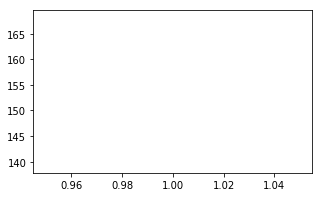

In [6]:
# Plotting train and test losses for all epochs
plot_losses(solver, 4)

In [ ]:
plot_gaussian_distributions(solver)

In [ ]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
                             solver.train_loss_history["train_loss_acc"], \
                             solver.test_loss_history, \
                             solver.train_loss_history["recon_loss_acc"], \
                             solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, 4)

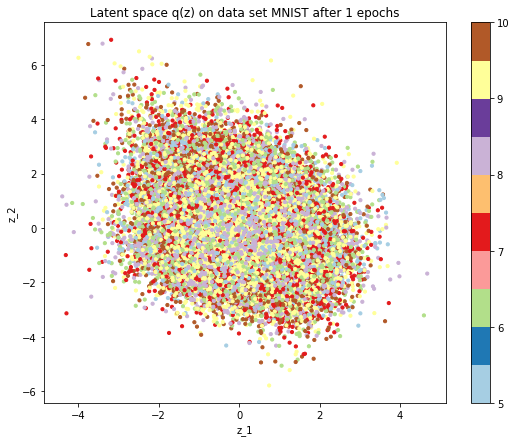

In [21]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    plot_latent_space(solver)
else:
    print("Plot of latent space not possible as dimension of z is not 2")

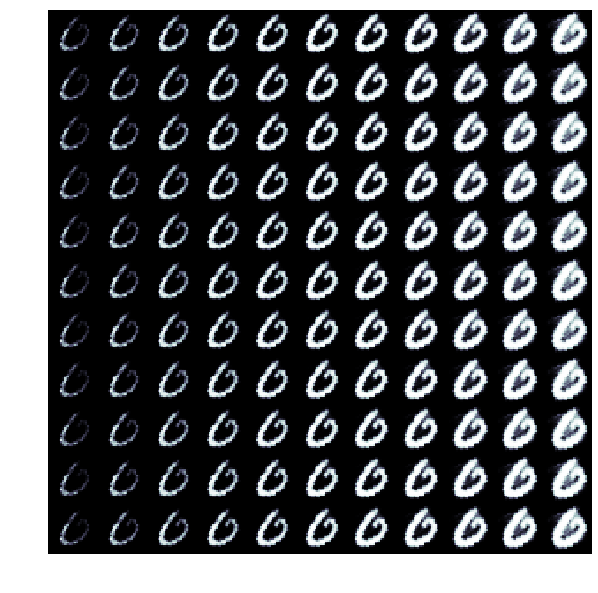

In [23]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    n = 11
    grid_x = np.linspace(-6, 6, n)
    grid_y = np.linspace(-6, 6, n)
    x_t = iter(solver.data_loader.train_loader).next()[0][0].view(-1, solver.data_loader.input_dim)
    plot_latent_manifold(solver, "bone", grid_x, grid_y, n, x_t=x_t)
else:
    print("Plot is not possible as dimension of z is not 2")

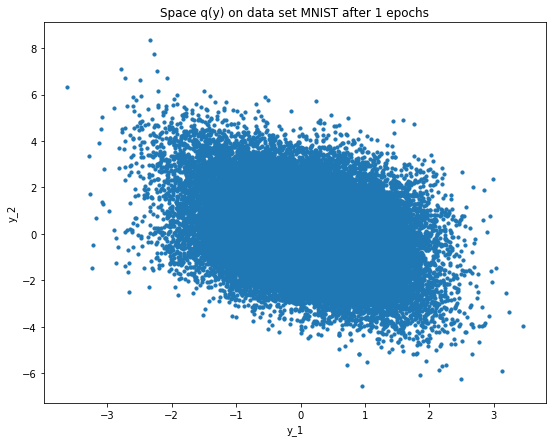

In [19]:
if solver.z_dim == 2:
    plot_y_space(solver)
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [ ]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
torch.save(solver, solver.save_model_dir + "/TD_CVAE_" + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")